In [19]:
#Zero Inflated Regression
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import norm
import matplotlib.pyplot as plt
#df = pd.read_csv('https://stats.idre.ucla.edu/stat/data/fish.csv')
df = pd.read_csv('fish.csv')
df = sm.add_constant(df)
df.head()

,const,nofish,livebait,camper,persons,child,xb,zg,count
0,1.0,1,0,0,1,0,-0.896315,3.050405,0
1,1.0,0,1,1,1,0,-0.558345,1.746149,0
2,1.0,0,1,0,1,0,-0.401731,0.279939,0
3,1.0,0,1,1,2,1,-0.956298,-0.601526,0
4,1.0,0,1,0,1,0,0.436891,0.527709,1


(array([236.,   7.,   5.,   0.,   1.,   0.,   0.,   0.,   0.,   1.]),
 array([  0. ,  14.9,  29.8,  44.7,  59.6,  74.5,  89.4, 104.3, 119.2,
        134.1, 149. ]),
 <BarContainer object of 10 artists>)

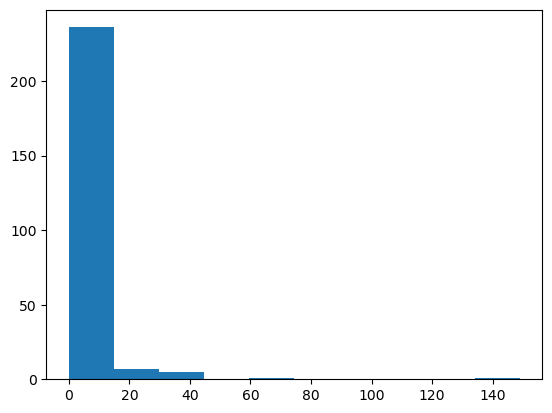

In [23]:
y = df['count']
x_vars = ['const', 'persons', 'child', 'camper']
X = df[x_vars]
x_infl_vars = ['const', 'persons', 'child', 'camper']
X_infl = df[x_infl_vars]
plt.hist(df['count'])

In [25]:
poisson_model = sm.GLM(endog=y, exog=X, family=sm.families.Poisson())
poisson_results = poisson_model.fit()
poisson_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  count   No. Observations:                  250
Model:                            GLM   Df Residuals:                      246
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -837.07
Date:                Wed, 17 Apr 2024   Deviance:                       1337.1
Time:                        09:31:19   Pearson chi2:                 2.91e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.9985
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.9818      0.152    -13.016      0.000      -2.280      -1.683
persons        1.0913      0.039     27.799      0.000       1.014       1.168
child         -1.6900      0.081    -20.866      0.000      -1.849      -1.531
camper         0.9309      0.089     10.450      0.000       0.756       1.106
==============================================================================
"""

In [27]:
#Zero Inflated Poisson Model
zip_model = sm.ZeroInflatedPoisson(endog=y, exog=X, exog_infl=X_infl, inflation='logit')
zip_results = zip_model.fit()
zip_results.summary()
#The coefficients in the Poisson count model show the effect of each predictor on the expected log count of the dependent variable.
#The coefficients in the zero-inflation model represent the effect of each predictor on the log odds of an observation being an excess zero.

Optimization terminated successfully.
         Current function value: 3.010926
         Iterations: 29
         Function evaluations: 31
         Gradient evaluations: 31


<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:                   count   No. Observations:                  250
Model:             ZeroInflatedPoisson   Df Residuals:                      246
Method:                            MLE   Df Model:                            3
Date:                 Wed, 17 Apr 2024   Pseudo R-squ.:                  0.3321
Time:                         09:31:20   Log-Likelihood:                -752.73
converged:                        True   LL-Null:                       -1127.0
Covariance Type:             nonrobust   LLR p-value:                6.123e-162
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
inflate_const       1.6636      0.503      3.308      0.001       0.678       2.649
inflate_persons    -0.9228      0.197     -4.689      0.000      -1.308      -0.537
inflate_child       1.9046      0.322      5.915      0.000       1.273       2.536
inflate_camper     -0.8336      0.350     -2.385      0.017      -1.519      -0.148
const              -0.7983      0.165     -4.830      0.000      -1.122      -0.474
persons             0.8290      0.043     19.415      0.000       0.745       0.913
child              -1.1367      0.091    -12.464      0.000      -1.315      -0.958
camper              0.7243      0.092      7.854      0.000       0.544       0.905
===================================================================================
"""

In [29]:
zip_y_hat = zip_results.predict(X)
zip_y_hat

0      0.332922
1      1.113192
2      0.332922
3      0.455713
4      0.332922
         ...   
245    3.578685
246    0.046123
247    0.455713
248    0.153481
249    0.455713
Length: 250, dtype: float64

In [31]:
#Vuong Test to see if ZIP model is needed - IS THIS WRONG?
ll_zip = zip_results.llf
ll_p = poisson_results.llf
ll_diff = ll_zip - ll_p

n = len(df)
n_params_zip_total = len(x_vars) + len(x_infl_vars)
n_params_poisson_total = len(x_vars)  

var_loglik_diff = (1 / n) * (ll_zip * (1 - ll_zip / n) + ll_p * (1 - ll_p / n))
vuong_stat = ll_diff / np.sqrt(ll_diff)

p_value = 2 * norm.sf(np.abs(vuong_stat))  # Two-tailed test

print("Vuong Statistic:", vuong_stat)
print("P-value:", p_value)

Vuong Statistic: 9.183734922144366
P-value: 4.1639277792919453e-20


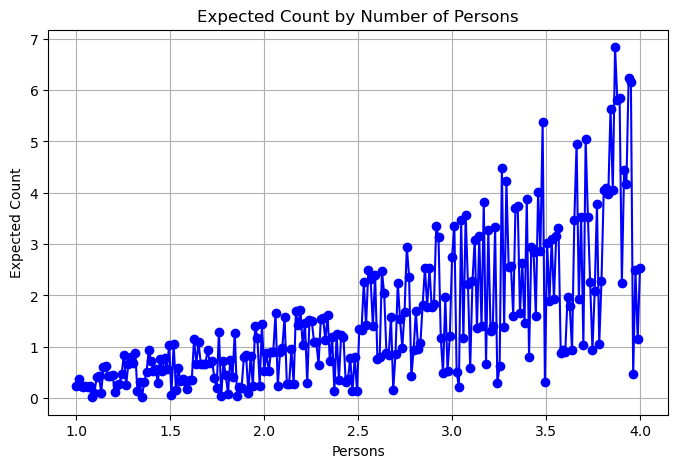

In [33]:
#Expected count simulation - # of people in group
mean_persons = X['persons'].mean()
mean_child = X['child'].mean()
mean_camper = X['camper'].mean()
n = len(X)

x_vars = ['const', 'persons', 'child', 'camper']

persons_span = np.linspace(X['persons'].min(), X['persons'].max(), len(X))
child_span = np.linspace(X['child'].min(), X['child'].max(), len(X))
camper_span = np.linspace(X['camper'].min(), X['camper'].max(), len(X))

prediction_frame = pd.DataFrame({
    'const': np.full(n, 1),
    'persons': persons_span,
    'child': np.full(n, mean_child),
    'camper': np.full(n, mean_camper),
})

zip_y_hat = zip_results.predict(prediction_frame)

plt.figure(figsize=(8, 5))
plt.plot(persons_span, zip_y_hat, marker='o', linestyle='-', color='blue')
plt.title('Expected Count by Number of Persons')
plt.xlabel('Persons')
plt.ylabel('Expected Count')
plt.grid(True)
plt.show()

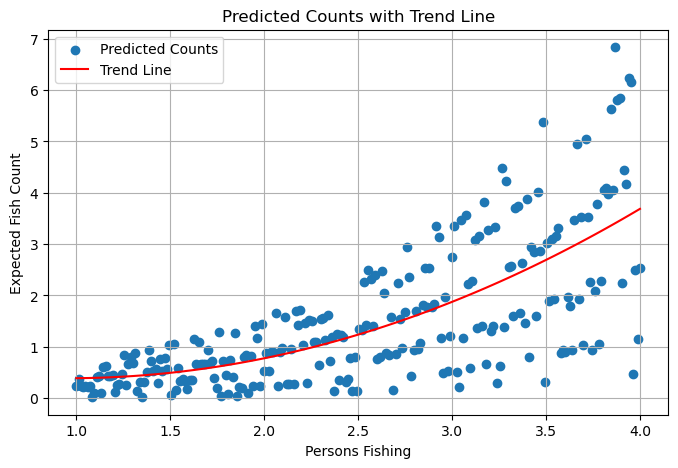

In [35]:
#Fitting a 2nd degree polynomial trend line
z = np.polyfit(persons_span, zip_y_hat, 2)
p = np.poly1d(z)
xp = np.linspace(min(persons_span), max(persons_span), 100)
py = p(xp)

plt.figure(figsize=(8, 5))
plt.scatter(persons_span, zip_y_hat, label='Predicted Counts')
plt.plot(xp, py, label='Trend Line', color='red')
plt.title('Predicted Counts with Trend Line')
plt.xlabel('Persons Fishing')
plt.ylabel('Expected Fish Count')
plt.legend()
plt.grid(True)
plt.show()

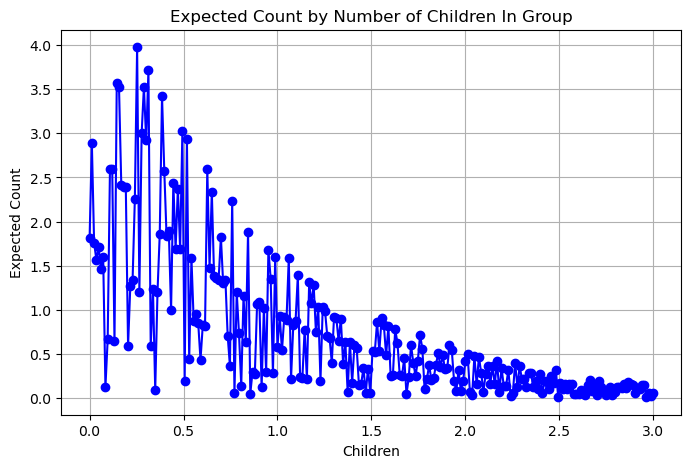

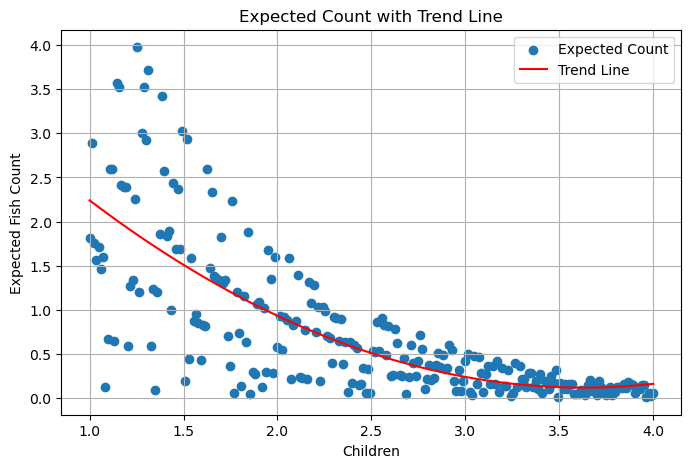

In [37]:
#Expected count simulation - # of children in group
mean_persons = X['persons'].mean()
mean_child = X['child'].mean()
mean_camper = X['camper'].mean()
n = len(X)

persons_span = np.linspace(X['persons'].min(), X['persons'].max(), len(X))
child_span = np.linspace(X['child'].min(), X['child'].max(), len(X))
camper_span = np.linspace(X['camper'].min(), X['camper'].max(), len(X))

prediction_frame = pd.DataFrame({
    'const': np.full(n, 1),
    'persons': np.full(n, mean_persons),
    'child': child_span,
    'camper': np.full(n, mean_camper),
})

zip_y_hat = zip_results.predict(prediction_frame)

plt.figure(figsize=(8, 5))
plt.plot(child_span, zip_y_hat, marker='o', linestyle='-', color='blue')
plt.title('Expected Count by Number of Children In Group')
plt.xlabel('Children')
plt.ylabel('Expected Count')
plt.grid(True)
plt.show()

#Fitting a 2nd degree polynomial trend line
z = np.polyfit(persons_span, zip_y_hat, 2)
p = np.poly1d(z)
xp = np.linspace(min(persons_span), max(persons_span), 100)
py = p(xp)

plt.figure(figsize=(8, 5))
plt.scatter(persons_span, zip_y_hat, label='Expected Count')
plt.plot(xp, py, label='Trend Line', color='red')
plt.title('Expected Count with Trend Line')
plt.xlabel('Children')
plt.ylabel('Expected Fish Count')
plt.legend()
plt.grid(True)
plt.show()

In [39]:
#Zero Inflated Negative Binomial Model - FAILING TO CONVERGE
#zinb_model = sm.ZeroInflatedNegativeBinomialP(endog=y, exog=X, exog_infl=X_infl, inflation='logit')
#zinb_results = zinb_model.fit(method='bfgs', maxiter=1000)
#print(zinb_results.summary())